# Multi-label text classification - Pytorch Lightning and Transformers

1. Data Acquisition and Data Cleaning
2. Build PyTorch Dataset
3. Build PyTorch-Lightning DataModule
4. Build PyTorch-Lightning Classifier using Transformers
5. Finetune (Train) the model
6. Test/Evaluate the model

In [290]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn
import pytorch_lightning as pl
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, AdamW

In [289]:
# random seed for re-producibility
pl.seed_everything(42)
# pre-trained model
MODEL_NAME = 'google/electra-small-discriminator'
# model parameters kept in config dict
config = {}

Global seed set to 42


## Data Acquisition and Data Cleaning

> Read data-files into pandas dataframe 

In [233]:
# read data in dataframes
dfs = []
for data_file in list(Path().glob('data/*.csv')):
    dfs.append(pd.read_csv(data_file))
# concatenate dataframes
emotions_df = pd.concat(dfs)
emotions_df.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,We can hope,ee3o3ko,darkenseyreth,EdmontonOilers,t3_ag4r9j,t1_ee3mhad,1.547529e+09,62,False,0,...,0,0,1,0,0,0,0,0,0,0
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
2,"Thank you so much, kind stranger. I really nee...",ed4fe9l,savageleaf,raisedbynarcissists,t3_abwh00,t1_ed4etbj,1.546482e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
3,Ion know but it would be better for you to jus...,efavtdu,CADDiLLXC,darknet,t3_al4njw,t3_al4njw,1.548800e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,1
4,I'm honestly surprised. We should have fallen ...,ee2imz2,CorporalThornberry,CollegeBasketball,t3_afxt6t,t1_ee22nyr,1.547497e+09,55,False,0,...,0,0,0,0,0,0,0,0,0,0


In [234]:
# inspect dataframe
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211225 entries, 0 to 69999
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   text                  211225 non-null  object 
 1   id                    211225 non-null  object 
 2   author                211225 non-null  object 
 3   subreddit             211225 non-null  object 
 4   link_id               211225 non-null  object 
 5   parent_id             211225 non-null  object 
 6   created_utc           211225 non-null  float64
 7   rater_id              211225 non-null  int64  
 8   example_very_unclear  211225 non-null  bool   
 9   admiration            211225 non-null  int64  
 10  amusement             211225 non-null  int64  
 11  anger                 211225 non-null  int64  
 12  annoyance             211225 non-null  int64  
 13  approval              211225 non-null  int64  
 14  caring                211225 non-null  int64  
 15  c

In [235]:
# out of 37 cols from 10 till 37 are the emotion labels 27 of them
all_labels = list(emotions_df.columns[9:])
all_labels

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [236]:
# there seems to be over 200k rows, lets check how many unique text items are there
len(emotions_df['id'].unique())

58011

In [237]:
# Unique ids are less than the total number of rows which means we have multiple rows for single id
# lets check one sample
emotions_df[emotions_df.id == "eebl3z7"]

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
1,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,76,False,0,...,0,0,0,0,0,0,0,0,0,0
32416,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,70,False,0,...,0,0,0,0,0,0,0,0,0,0
38752,Shhh don't give them the idea!,eebl3z7,BoinkBoinkEtAliae,MurderedByWords,t3_ah3o76,t1_eeb68lo,1.547777e+09,3,False,0,...,0,0,0,0,1,0,0,0,0,0


> rater-id is different which means same text is rated by three different people and they might provide differnt emotions for same text. we'll keep only one row for each unique text id.For this we'll sum-up each emotion for given text id and assign it emotion with largest count.  
For example, for this id the majority label is 'anger' 

In [238]:
# idxmax retuens the 'index' with maximum value for a given axis
# axis=1 means we want to get the column with maximum value for each row
emotions_df[emotions_df.id == "eebl3z7"][labels].sum().idxmax(axis=1) 

'anger'

> Lets do this for for whole dataset. At the end we want a dataframe with unique text and associated majority label

In [239]:
# get majority label (column with largest value) for each 'id'
labels_sr = emotions_df.groupby('id').sum()[labels].idxmax(axis=1)
labels_df = pd.DataFrame(labels_sr, columns=['emotion'])
# create a target numeric column 'label' corresponding to the emotion index
labels_df['label'] = labels_df['emotion'].apply(lambda x: all_labels.index(x))
labels_df

,emotion,label
id,,
eczazk6,approval,4
eczb07q,neutral,27
eczb4bm,disappointment,9
eczb527,curiosity,7
eczb6r7,neutral,27
...,...,...
efhclgb,confusion,6
efhcm78,annoyance,3
efhcnhz,neutral,27


In [240]:
# extract the unique ids and associted text from data
# median is used here just to get a data-frame out from groupby object (this is something I don't understand in pandas vs SQL)
# the reset_index is used to make `id` and `text` and clolumns and not index so that we can extract them, groupby makes columns used 
# to group as index
emotions_df = emotions_df.groupby(['id', 'text']).median().reset_index()[['id', 'text']]
# setting id as index 
emotions_df.set_index('id', inplace=True)
emotions_df

,text
id,
eczazk6,Fast as [NAME] will carry me. Seriously uptown...
eczb07q,You blew it. They played you like a fiddle.
eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...
eczb527,So much time saved. Not.
eczb6r7,Emotes have a ridiculous amount of effort put ...
...,...
efhclgb,[NAME]. I’m not sure you’ll feel the same way ...
efhcm78,I can see why! I would totally be offended too!
efhcnhz,Approaching doesn't work unless you are [NAME]...


In [241]:
# now concatenate text and lables to get our dataset, could just use concat here
# but using join will ensure that correct ids and text get their respective labels
emotions_df = emotions_df.join(labels_df, how='left')
emotions_df.head()

,text,emotion,label
id,,,
eczazk6,Fast as [NAME] will carry me. Seriously uptown...,approval,4
eczb07q,You blew it. They played you like a fiddle.,neutral,27
eczb4bm,TL;DR No more Superbowls for [NAME]. Get ready...,disappointment,9
eczb527,So much time saved. Not.,curiosity,7
eczb6r7,Emotes have a ridiculous amount of effort put ...,neutral,27


plot the label distribution

neutral           16254
admiration         5387
approval           3749
annoyance          3476
gratitude          3031
amusement          2973
anger              2353
curiosity          2291
disapproval        2199
love               2048
confusion          1607
disappointment     1359
caring             1317
optimism           1315
joy                1308
sadness            1163
surprise           1005
realization         916
excitement          850
disgust             779
desire              694
fear                674
remorse             523
embarrassment       316
nervousness         140
relief              117
pride                86
grief                81
Name: emotion, dtype: int64



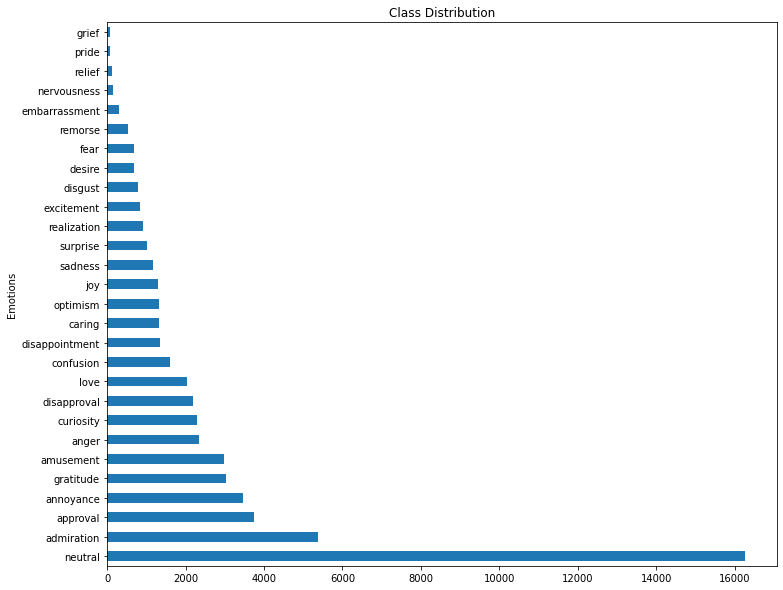

In [242]:
print(emotions_df['emotion'].value_counts())
print()
emotions_df['emotion'].value_counts().plot(kind='barh', figsize=(12, 10), title='Class Distribution', xlabel='Emotions')
plt.show()

sequnce models requires fixed length inputs. Lets  find out the approx maximum text length i.e. number of token

In [243]:
# downloand the tokennizer
tokenizer = ElectraTokenizerFast.from_pretrained(MODEL_NAME)

In [244]:
# tokenize the text
token_dict = tokenizer(emotions_df['text'].tolist())

In [245]:
print(f'Raw Text:\n{emotions_df["text"].iloc[0]}\n')
print(f'Tokenized Text:\n{token_dict.tokens(0)}\n')
print(f'Token Ids:\n{token_dict["input_ids"][0]}')

Raw Text:
Fast as [NAME] will carry me. Seriously uptown to downtown via Claiborne or broad isn’t that bad

Tokenized Text:
['[CLS]', 'fast', 'as', '[', 'name', ']', 'will', 'carry', 'me', '.', 'seriously', 'uptown', 'to', 'downtown', 'via', 'cl', '##ai', '##borne', 'or', 'broad', 'isn', '’', 't', 'that', 'bad', '[SEP]']

Token Ids:
[101, 3435, 2004, 1031, 2171, 1033, 2097, 4287, 2033, 1012, 5667, 28539, 2000, 5116, 3081, 18856, 4886, 19288, 2030, 5041, 3475, 1521, 1056, 2008, 2919, 102]


> We see that most of the sentences are maximum upto 52 tokens long. We'll use 60 as max-length

<AxesSubplot:>

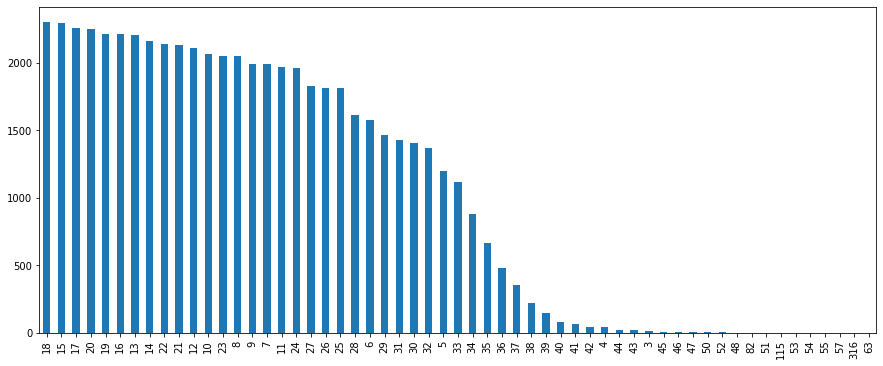

In [246]:
pd.Series([len(tokens) for tokens in token_dict['input_ids']]).value_counts().plot(kind='bar', figsize=(15, 6))

## Build PyTorch Dataset

In [253]:
class EmotionsDataset(Dataset):
    def __init__(self, df, tokenizer, config):
        super().__init__()
        self.tokenizer = tokenizer
        self.config= config
        self.df = df
                
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        token_dict = self.tokenizer(row[config['text_col']], 
                                    max_length=config['max_len'], 
                                    padding='max_length',
                                    truncation=True,
                                    return_token_type_ids=False,
                                    return_tensors="pt",
                                    add_special_tokens=True)
        row_dict = {'input_ids':token_dict['input_ids'].flatten(),
                    'attention_mask':token_dict['attention_mask'].flatten(),
                    'labels':torch.tensor(row[config['target_col']])
                   }
        return row_dict

In [254]:
# Quick test the dataset implementation
tokenizer = ElectraTokenizerFast.from_pretrained(MODEL_NAME)
config['max_len'] = 60
config['text_col'] = 'text'
config['target_col'] = 'label'
ds = EmotionsDataset(emotions_df, tokenizer, config)
len(ds)

58011

In [255]:
# dataset returns a dict with tokens (with length 60) and associted label id
ds[0]

{'input_ids': tensor([  101,  3435,  2004,  1031,  2171,  1033,  2097,  4287,  2033,  1012,
          5667, 28539,  2000,  5116,  3081, 18856,  4886, 19288,  2030,  5041,
          3475,  1521,  1056,  2008,  2919,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor(4)}

## Build PyTorch-Lightning DataModule

In [256]:
class EmotionsDataModule(pl.LightningDataModule):
    def __init__(self, data_path, tokenizer, config):
        super().__init__()
        self.data_path = data_path
        self.tokenizer = tokenizer
        self.config = config

    # Helper method for pre-processing    
    def __preprocess_data(self):
        # read data in dataframes
        dfs = []
        for data_file in list(Path().glob(self.data_path + '/*.csv')):
            dfs.append(pd.read_csv(data_file))
        # concatenate dataframes
        df = pd.concat(dfs)
        # 10th cols till 37th are the emotion labels, 27 of them
        all_labels = list(df.columns[9:])
        # get majority label (column with largest value) for each 'id'
        labels_sr = df.groupby('id').sum()[labels].idxmax(axis=1)
        labels_df = pd.DataFrame(labels_sr, columns=['emotion'])
        # create a target numeric column 'label' corresponding to the emotion index
        labels_df['label'] = labels_df['emotion'].apply(lambda x: all_labels.index(x))
        # extract the unique ids and associted text from data
        df = df.groupby(['id', 'text']).median().reset_index()[['id', 'text']]
        # setting id as index 
        df.set_index('id', inplace=True)
        # now join text and lables to get our dataset 
        df = df.join(labels_df, how='left')
        return df        
 

    # setup method is called only once and its for tasks such as
    # loading data from files into objects, pre-processing, formatting
    # creating train, val, test split
    def setup(self, stage=None):
        # preprocess raw data from files 
        emotions_df = self.__preprocess_data()
        # split data in train and test set
        self.train_df, self.test_df = train_test_split(emotions_df, test_size=self.config['test_size'], shuffle=True)
        # further split train data in train and val set
        self.train_df, self.val_df = train_test_split(self.train_df, test_size=self.config['val_size'], shuffle=True)
    
    
    def train_dataloader(self):
        return DataLoader(EmotionsDataset(self.train_df, self.tokenizer, self.config),
                          batch_size=self.config['batch_size'],
                          num_workers=os.cpu_count(),
                          shuffle=True)
    
    
    def val_dataloader(self):
        return DataLoader(EmotionsDataset(self.val_df, self.tokenizer, self.config),
                          batch_size=self.config['batch_size'],
                          num_workers=os.cpu_count(),
                          shuffle=False)

    
    def test_dataloader(self):
        return DataLoader(EmotionsDataset(self.test_df, self.tokenizer, self.config),
                          batch_size=self.config['batch_size'],
                          num_workers=os.cpu_count(),
                          shuffle=False)

In [263]:
# Quick test datamodule implementation
data_path = './data'
tokenizer = ElectraTokenizerFast.from_pretrained(MODEL_NAME)
config['max_len'] = 60
config['text_col'] = 'text'
config['target_col'] = 'label'
config['val_size'] = 0.2
config['test_size'] = 0.2
config['batch_size'] = 32

# Instantiate datamodule
dm = EmotionsDataModule(data_path, tokenizer, config)
dm.setup()
train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()
test_dl = dm.test_dataloader()

# fetch a batch from dataloaders
batch = iter(train_dl).next()
print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape)
print(batch)
print()
batch = iter(val_dl).next()
print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape)
print(batch)
print()
batch = iter(test_dl).next()
print(batch['input_ids'].shape, batch['attention_mask'].shape, batch['labels'].shape)
print(batch)
print()

torch.Size([32, 60]) torch.Size([32, 60]) torch.Size([32])
{'input_ids': tensor([[  101,  2053, 15876,  ...,     0,     0,     0],
        [  101,  1045,  2001,  ...,     0,     0,     0],
        [  101,  2131,  2092,  ...,     0,     0,     0],
        ...,
        [  101,  1996,  2160,  ...,     0,     0,     0],
        [  101,  2008,  1005,  ...,     0,     0,     0],
        [  101,  2004,  1037,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([ 2,  4,  5, 27, 27,  3, 17, 27, 15, 27, 15, 27, 20,  7,  3,  6, 10,  4,
         4,  2, 18, 27, 18, 17, 27,  2, 18, 27,  0,  0, 27, 10])}

torch.Size([32, 60]) torch.Size([32, 60]) torch.Size([32])
{'input_ids': tensor([[ 101, 2748, 1010,  ...,    0,    0,    0],
        [ 101, 9826, 1010,  ...,    0,    0, 

## Build PyTorch-Lightning Classifier using Transformers

In [ ]:
class EmotionClassifier(pl.LightningDataModule):
    def __init__(self, config):
        self.config = config
        self.model = ElectraForSequenceClassification.from_pretrained(config['model_name'], 
                                                                      problem_type='multi_label_classification')
    
    def forward(self, batch, batch_idx):
        
                
                                                                             
    def configure_optimizer:
        pass

In [ ]:
# Quick test model implementation
data_path = './data'
tokenizer = ElectraTokenizerFast.from_pretrained(MODEL_NAME)
config['max_len'] = 60
config['text_col'] = 'text'
config['target_col'] = 'label'
config['val_size'] = 0.2
config['test_size'] = 0.2
config['batch_size'] = 32
config['model_name'] = MODEL_NAME
config['learning_rate'] = 1e-5
config['optimizer'] = 
# Instantiate datamodule
dm = EmotionsDataModule(data_path, tokenizer, config)
dm.setup()
# Instantiate a pre-trained model
pre_trained_model = 

## Finetune (Train) the transformer model

## Test/Evaluate the model

<class 'tuple'>
(1, 2, 3, 4, 5)
